In [1]:
# import all the packages
import pandas as pd
import numpy as np
import math
import threading
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from scipy.stats import ttest_ind


# load the data
data = pd.read_csv("flights.csv")
airlines = pd.read_csv("airlines.csv")
airports = pd.read_csv("airports.csv")


def preprocess(data, n):

    def clean_variables_no_info(data):
        """
        Description: drops columns that provide no information

        :param data: flights dataframe
        :return: returns cleaned dataframe
        """

        NAs_to_remove = ["Quarter", "Flight_Number_Reporting_Airline", "Div5TailNum", "Div5WheelsOff",
                         "Div5LongestGTime",
                         "Div5LongestGTime", "Div5TotalGTime", "Div5WheelsOn", "Div5AirportSeqID",
                         "Div5AirportID", "Div5Airport", "Div4TailNum", "Div4WheelsOff", "Div4LongestGTime",
                         "Div4TotalGTime", "Div4WheelsOn", "Div4AirportSeqID", "Div4AirportID", "Div4Airport",
                         "Div3TailNum", "Div3WheelsOff", "Div3LongestGTime", "Div3TotalGTime", "Div3WheelsOn",
                         "Div3AirportSeqID", "Div3AirportID", "Div3Airport", "Div2TailNum", "Div2WheelsOff",
                         "Div2LongestGTime", "Div2TotalGTime", "Div2WheelsOn", "Div2AirportSeqID", "Div2AirportID",
                         "Div2Airport", "Div1TailNum", "Div1WheelsOff", "Div1LongestGTime", "Div1TotalGTime",
                         "Div1WheelsOn", "Div1AirportSeqID", "Div1AirportID", "Div1Airport", "DivDistance",
                         "DivArrDelay", "DivActualElapsedTime", "DivReachedDest", "DivAirportLandings",
                         "LongestAddGTime", "DistanceGroup", "CancellationCode", "DestState", "DestStateFips",
                         "DestStateName", "DestWac", "OriginWac", "OriginStateName", "OriginStateFips",
                         "OriginState", "FirstDepTime", "TotalAddGTime", "Cancelled", "Unnamed: 109", "OriginCityName",
                         "ArrDelay", "DepTime", "WheelsOff", "WheelsOn"]

        cleaned_data = data.drop(NAs_to_remove, axis=1)

        return cleaned_data

    def clean_variables_multcol(data):
        """
        Description: drops columns that can create multicollinearity issues

        :param data: flights dataframe
        :return: cleaned dataframe
        """

        other_columns = ["FlightDate", "Reporting_Airline", "Tail_Number",
                         "DOT_ID_Reporting_Airline",
                         "OriginAirportID", "OriginAirportSeqID", "OriginCityMarketID",
                         "DestAirportID", "DestAirportSeqID", "DestCityMarketID", "DestCityName",
                         "DepDelay", "DepartureDelayGroups", "DepTimeBlk", "ArrTime", "ArrivalDelayGroups",
                         "ArrTimeBlk",
                         "Diverted", "AirTime", "Flights"]

        cleaned_data = data.drop(other_columns, axis=1)

        return cleaned_data

    def clean_variables_delay(data):
        """
        Description: drops delay related columns out of the flight dataset

        :param data: dataframe we want to clean
        :return: cleaned dataframe
        """

        pot_vars = ["CarrierDelay", "WeatherDelay",
                    "NASDelay", "SecurityDelay", "LateAircraftDelay"]

        cleaned_data = data.drop(pot_vars, axis=1)

        return cleaned_data

    def delaytype(data):
        """
        Description: creates a new column that categorizes the delay in minutes into 7 categories

        :param data: flights data with a delay column in minutes
        :return: dataframe with the new column
        """

        my_list = []

        for x in data["DepDelayMinutes"]:
            if x < 15:
                my_list.append(0)
            elif x < 30:
                my_list.append(1)
            elif x < 45:
                my_list.append(2)
            elif x < 60:
                my_list.append(3)
            elif x < 90:
                my_list.append(4)
            elif x < 120:
                my_list.append(5)
            else:
                my_list.append(6)

        data["Del_type"] = my_list

        return data

    def round_hours(data):
        """
        Description: transforms the appropiate time columns into hours in the flights dataset

        :param data: flights dataframe
        :return: dataset with the new hour columns
        """

        data.dropna(subset=["CRSDepTime", "CRSArrTime"], inplace=True)

        return_hour(data, "CRSDepTime")
        return_hour(data, "CRSArrTime")

        data.drop(["CRSDepTime",  "CRSArrTime"], axis=1, inplace=True)

        return data

    def return_hour(data, column):
        """
        Description: returns the hour rounded down for a time element in military format

        :param data: dataframe with the new column
        :param column: time column to be transformed
        :return: dataframe with the new column
        """

        my_list = []

        for x in data[column]:
            a = math.floor(x / 100)
            my_list.append(a)

        data[column + "Hour"] = my_list

        return data

    def dummy_generator(data, column, airports):
        """
        Description: Generates dummy variables for a specified list of airports (1 if the airport specified, 0 if not)

        :param data: dataframe where one wants to add the dummy column
        :param column: string indicating which column the function will look at to generate the dummys
        :param airports: list indicating the number of dummy variables to be generate
        :return: dataframe with the new columns
        """

        for x in airports:
            my_list = []
            for y in data[column]:
                if x == y:
                    my_list.append(1)
                else:
                    my_list.append(0)
            data["dummy" + str(column) + str(x)] = my_list

        return data

    n = number_of_airports_included

    main_origins = data[["Origin", "Dest"]].groupby(["Origin"]).count().sort_values(by="Dest", ascending=False).head(
        n).reset_index()["Origin"]

    main_dests = data[["Dest", "Origin"]].groupby(["Dest"]).count().sort_values(by="Origin", ascending=False).head(
        n).reset_index()["Dest"]

    data = data[data["Origin"].isin(main_origins) & data["Dest"].isin(main_dests)]

    

    data = clean_variables_no_info(data)
    data = clean_variables_multcol(data)
    data = clean_variables_delay(data)
    data = delaytype(data)
#    data = round_hours(data)
    data = dummy_generator(data, "Origin", main_origins)
    data = dummy_generator(data, "Dest", main_dests)
    data.drop(["IATA_CODE_Reporting_Airline", "Origin", "Dest"], axis=1, inplace=True)

    return data


number_of_airports_included = 50
data = preprocess(data, number_of_airports_included)


def Airport(airports):
    # Function finds city and airport
    identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()
    latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
    longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

    return


def Airlines(self):
    # Function locates all the different airlines and names them

    return


def DelayType(self):
    # Function finds categorizes delay into groups based on minute
    # For example early arrival, on time, less than 15 min etc..
    def delay_type(x): return ((0, 1)[x > 5], 2)[x > 30]
    df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
    return


def DelaySort(self):
    # Function that finds the reason for the delay
    # Either delay in departure or arrival
    # i.e. caused by extra unexpected flight duration or not

    return


def CompareAirlines(self):
    # Function that compares the airlines on:
    # Basic statistical description of airlines
    # Delays distribution: establishing the ranking of airlines
    def get_stats(group):
        return {'min': group.min(), 'max': group.max(),
                'count': group.count(), 'mean': group.mean()}

    global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
    global_stats = global_stats.sort_values('count')
    return global_stats


def CompareAirports(self):
    # Function that compares the airports on:
    # Basic statistical description of airports
    # Delays distribution: establishing the ranking of airports

    return


def PredictingDelayMain(self):
    # function summarizer all the methods which predict the chance of a delay

    return


def ComparePredictingDelay(self):
    # function that compares the predictions

    return


def PredictingDelay1(self):
    # function that predicts the chance of a delay by using ....

    return


def PredictingDelay2(self):
    # function that predicts the chance of a delay by using ....

    return


def PredictingDelay3(self):
    # function that predicts the chance of a delay by using ....

    return


def PredictingDelay4(self):
    # function that predicts the chance of a delay by using ....

    return



//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (48,69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelayMinutes,DepDel15,TaxiOut,TaxiIn,CRSArrTime,...,dummyDestMCI,dummyDestPIT,dummyDestCMH,dummyDestIND,dummyDestCVG,dummyDestCLE,dummyDestSAT,dummyDestSNA,dummyDestRSW,dummyDestJAX
225,2019,11,21,4,1015,0.0,0.0,24.0,3.0,1200,...,0,0,0,0,0,0,0,0,0,0
226,2019,11,22,5,1015,23.0,1.0,24.0,6.0,1200,...,0,0,0,0,0,0,0,0,0,0
227,2019,11,24,7,1015,0.0,0.0,29.0,8.0,1200,...,0,0,0,0,0,0,0,0,0,0
228,2019,11,26,2,1015,0.0,0.0,19.0,4.0,1200,...,0,0,0,0,0,0,0,0,0,0
229,2019,11,27,3,1015,2.0,0.0,27.0,7.0,1200,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data["DayOfWeek"].unique()
list(data.columns)
data = data.drop(["TaxiOut","TaxiIn","DepDelayMinutes",
                 "DepDel15","ArrDelayMinutes","CRSElapsedTime",
                 "Distance","CRSArrTime","Del_type"],axis=1) 

data = data.drop("ActualElapsedTime",axis=1)
data.head()
#list(data.columns)

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,ArrDel15,dummyOriginATL,dummyOriginORD,dummyOriginDFW,dummyOriginDEN,...,dummyDestMCI,dummyDestPIT,dummyDestCMH,dummyDestIND,dummyDestCVG,dummyDestCLE,dummyDestSAT,dummyDestSNA,dummyDestRSW,dummyDestJAX
225,2019,11,21,4,1015,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
226,2019,11,22,5,1015,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227,2019,11,24,7,1015,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
228,2019,11,26,2,1015,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
229,2019,11,27,3,1015,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Anstatt Klassifikation, target variable als minuten und lineare Reg machen?

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from IPython.display import HTML
from sklearn.metrics import accuracy_score
from sklearn import tree
from graphviz import Source
from IPython.display import SVG, display
from ipywidgets import interactive

from sklearn import preprocessing

# PREPROCESSING & MODEL SELECTION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

# STANDARD MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# ENSEMBLE
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# XGBOOST
#from xgboost import XGBClassifier
data = data.dropna()

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop('ArrDel15', axis=1)
y = data['ArrDel15']

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)



#### 3: Create Function fo evaluation everything

def evaluation_times(X,y,n_splits=10, shuffle=True, random_state=0):
    
    X_std = StandardScaler().fit_transform(X)
    X_minmax = MinMaxScaler().fit_transform(X)
    
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    features = [('Normal',       X), 
                ('Standardized', X_std), 
                ('MinMax',       X_minmax)]
    
    models = [('LogisticRegression',         LogisticRegression(solver="lbfgs",multi_class="auto")),
              ('KNeighborsClassifier',       KNeighborsClassifier()),
              ('Naive Bayes',                GaussianNB()),
              ('DecisionTreeClassifier',     DecisionTreeClassifier()),
              ("RandomForestClassifier",     RandomForestClassifier()),
              ("GradientBoostingClassifier", GradientBoostingClassifier())]
    
    
    results = []
    
    for model in models:
        
        for feature in features:
            
            res = cross_val_score(model[1], feature[1], y, cv=kfold)
            
            [results.append((model[0],feature[0],model[0]+'_'+feature[0], r)) for r in res]
            
            print(res)
        
            
    result = pd.DataFrame(results,columns=['Model','Feature','FeatureScaled_Model', 'Result'])
    
    return result     

evalu = evaluation_times(X,y,n_splits=10, shuffle=True, random_state=0)
      
evalu.head()

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

,Model,Feature,FeatureScaled_Model,Result
0,LogisticRegression,Normal,LogisticRegression_Normal,0.856767
1,LogisticRegression,Normal,LogisticRegression_Normal,0.856395
2,LogisticRegression,Normal,LogisticRegression_Normal,0.856910
3,LogisticRegression,Normal,LogisticRegression_Normal,0.855193
4,LogisticRegression,Normal,LogisticRegression_Normal,0.855336


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

Times Results:


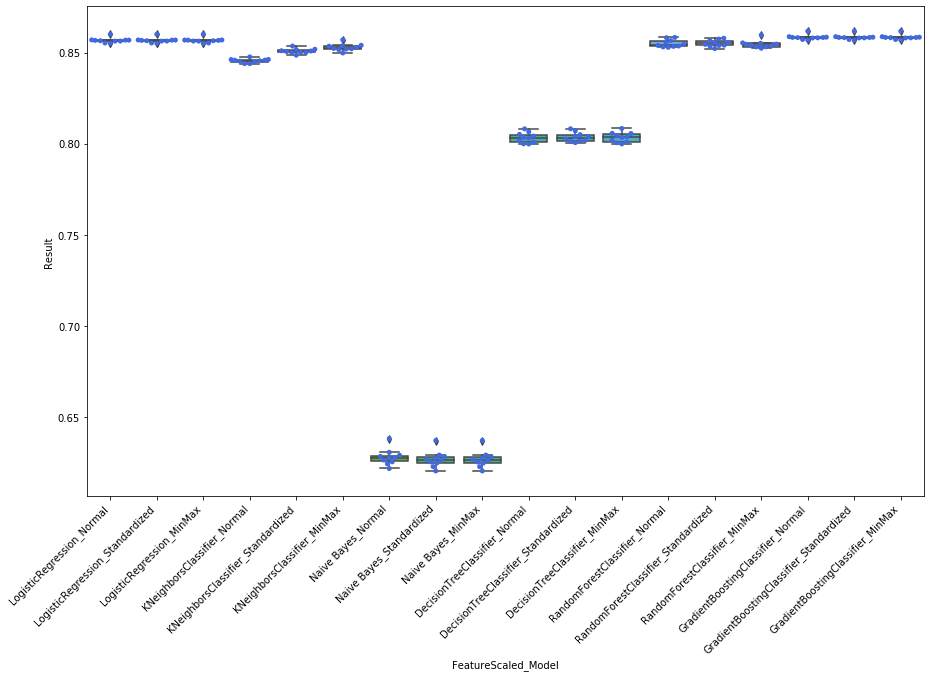

In [6]:
results = evaluation_times(X, y)

plt.figure(figsize=(15,9))
chart = sns.boxplot(data=results, x='FeatureScaled_Model', y='Result')
chart = sns.swarmplot(data=results, x='FeatureScaled_Model', y='Result', color="royalblue")
chart.set_xticklabels(labels=results['FeatureScaled_Model'].unique(), rotation=45, horizontalalignment='right')

print('Times Results:')



In [2]:
results

NameError: name 'results' is not defined